## Data Science in 30 Minutes

We do things in Python:

1. We love IPython notebook as a pedagogical tool.
1. Python strikes a good balance between flexibility (it's interpreted) and speed (core machine-learning and linear algebra is in c via [cython](http://cython.org/)).
1. Python strikes a good balance between being a programming language (it has a lot of language support built up by the community) and specialized machine-learning routines (e.g. [numpy](http://www.numpy.org/), [scipy](http://www.scipy.org/), [scikit learn](http://scikit-learn.org/), [pandas](http://pandas.pydata.org/)).
1. The downside of using Python is that installation and dependency management is a pain.  Installing Python is dev-ops work: there's a steep learning curve and you only really need to do it once: unfortunately, you need to be able to do it before you can start using the tools.  If you have the time, you should invest some time in learning about [pip](http://pip.readthedocs.org/en/stable/installing/) and [Virtual Environments](https://virtualenv.pypa.io/en/latest/), although even then, installing scientific python can be a pain.  One of the advantages of being a fellow at [The Data Incubator](https://www.thedataincubator.com/&ref=ds30) is that they get an environement with all the tooling installed.

In [1]:
# Importing graphics related libraries
%matplotlib inline
import matplotlib
import seaborn as sns  # plots are prettier with Seaborn
import onlineldavb
from wordcloud import WordCloud
from IPython.display import Image
from IPython import display
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# importing useful libraries
import simplejson  # more efficient than the default json library
import sys
import requests  # better than the urllib libraries
from requests_oauthlib import OAuth1
from collections import Counter
import heapq
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from itertools import islice, chain
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt


## Setup twitter authorization

1. Need to authenticate (can you guess why?).  Creat a twitter account and get your API credentials on the [Twitter API page](http://apps.twitter.com/).
1. Secrets not checked into source control (good practice)!
1. Using python `stream` (like an infinite list!)
1. Handle stream using python `generator`
1. *Protip*: `simplejson` is faster than builtin `json`.
1. *Protip*: `requests` is easier to use than builtin `urllib`.

In [7]:
with open("twitter_secrets.json.nogit") as fh:
    secrets = simplejson.loads(fh.read())

auth = OAuth1(
    secrets["api_key"],
    secrets["api_secret"],
    secrets["access_token"],
    secrets["access_token_secret"]
)

US_BOUNDING_BOX = "-125.00,24.94,-66.93,49.59"
def tweet_generator():
    """ Generator that live streams tweets (see 'yield' keyword)"""
    stream = requests.post('https://stream.twitter.com/1.1/statuses/filter.json',
                         auth=auth,
                         stream=True,
                         data={"locations" : US_BOUNDING_BOX})
    
    for line in stream.iter_lines():
        if not line:  # filter out keep-alive new lines
            continue
        tweet = simplejson.loads(line)
        if 'text' in tweet:
            yield tweet['text']

## Try out twitter stream

1. When handling streams, need to use `itertools` (`slice` -> `islice`)

In [8]:
for tweet in islice(tweet_generator(), 100):
    print tweet

@CapitalOne is something wrong with ur auto phone number line. I've been calling for days to make a payment.
what time u get off? @TailorMade11
@SamoneTaylorxxx one of those days, huh?
Can Halloween weekend just be here already😻🎃👻🍂🍁🔥
Need some artwork for the apartment and to paint the walls then I'll be done ...
When someone thinks their pee is light enough to where they don't need to flush! nigga I know this isn't water!! 😩😩😩
Having a good day😇
Oh that look and walk when you hit a SF cop on Montgomery and market Street http://t.co/KZgEjLK1gK
New Life who dis
@Hadi_YouDo listen to wood would and quarterback and chosen one and you'll understand
@AllenWest @debbierose4444 Also wondering how many ISIS training camps scattered around the USA, do you know? Thanks. May God bless America!
@Kristenng28 oh shit yeah fixing it once sec
@Jetjaguar67 you can send them to me- mmmmmm!
😍  https://t.co/7wolqEBr2q
Blow up my mentions dgaf
You have to actually touch the base when you catch the ball for

## Aggregate Statistics

1. Raw tweets less interesting than word counts
1. Stop words necessary for NLP
1. Leverage standard library functions and classes (e.g. `Counter`)
1. Don't count iterations manually, use `enumerate`
1. Don't print each iteration
1. Difference between `\r` vs. `\n` and `print` vs. `sys.stdout.write`
1. Capture `KeyboardInterrupt` makes output prettier
1. `nlargest` should be computed using Heap Queue
    ![Heap Queue](heapqueue.png)

[('-', 55), ('#job', 55), ('#hiring', 53), ("i'm", 46), (u'like', 41), ("it's", 39), ('#careerarc', 38), (u"don't", 35), ('@', 34), ('#jobs', 34)]

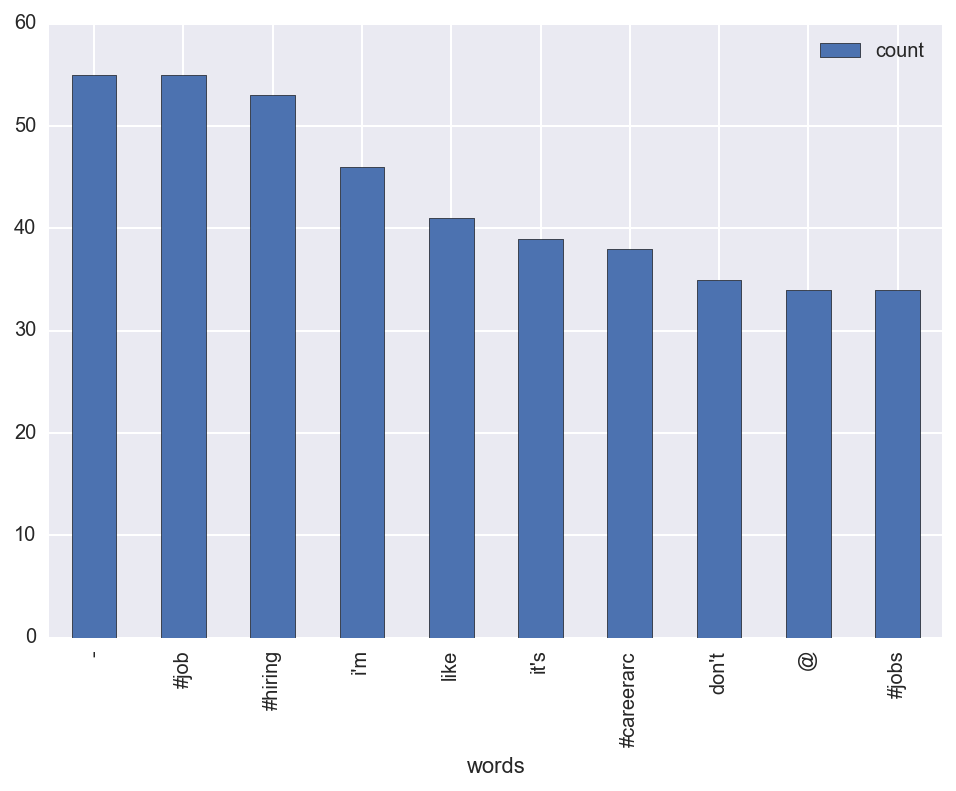

In [9]:
DISPLAY_EVERY = 100

stop = set(stopwords.words('english'))  # predefined list of "uninteresting" words

counter = Counter()

def nlargest(n, word_scores):
    """ Wrapper around heapq to return the n words with the largest count."""
    # word_scores: index 0=>word, 1=>count
    return heapq.nlargest(n, word_scores, key=lambda x: x[1])

try:
    # islice allows you to get some # of values out of a generator.
    for k, tweet in enumerate(islice(tweet_generator(), 1000)):
        for word in tweet.lower().split():  # lowercase, split by whitespace
            if word not in stop:  # avoid uninteresting words
                counter[word] += 1
        if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):  # only update text every so often
            # \r will overwrite updates, rather than listing them out
            # one on each newline
            sys.stdout.write("\r" + str(nlargest(10, counter.items())))
except KeyboardInterrupt:
    pass  # allow ctrl-c to exit the loop
finally:
    # Demo to show that Pandas has bar graphs...
    # ...and that seaborn makes it pretty!
    df = pd.DataFrame(nlargest(10, counter.items()), columns=['words', 'count'])
    df.set_index('words').plot(kind='bar')

## Visualize

1. Lists of word counts not as useful
1. Wordcloud: size of word ~ frequency (there's a library for that)


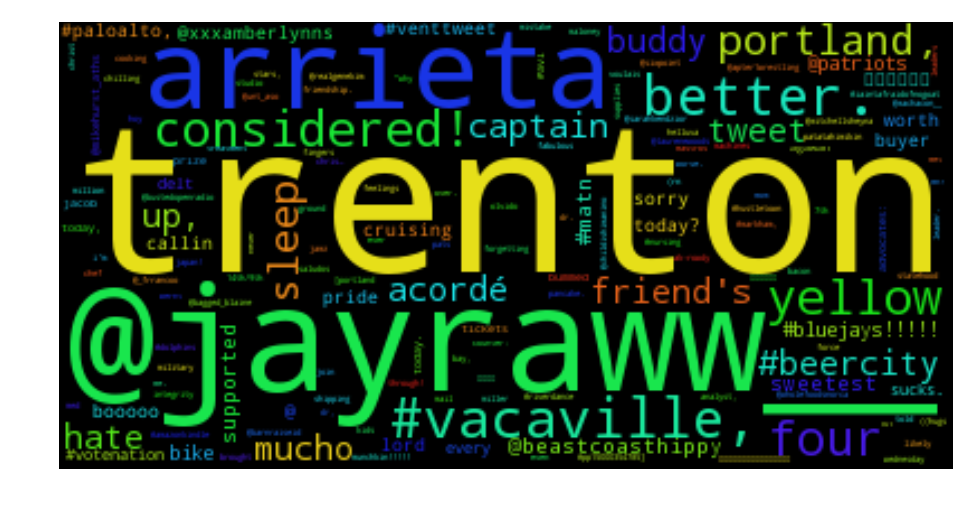

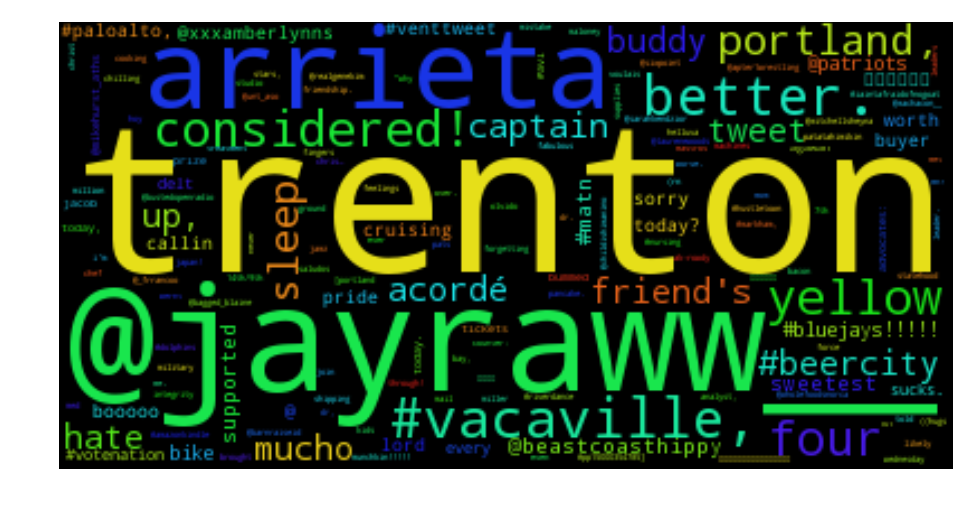

In [11]:
counter = Counter()
try:
    for k, tweet in enumerate(islice(tweet_generator(), 1000)):
        for word in tweet.lower().split():
            if word not in stop and 'http' not in word:
                counter[word] += 1
        if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):
            wordcloud = WordCloud().fit_words(counter.items())
            plt.axis("off")
            display.clear_output(wait=True)
            plt.imshow(wordcloud)
            display.display(plt.gcf())
except KeyboardInterrupt:
    pass

## Topic Modelling

1. Batch tweets (another generator)
1. Online vs offline
    1. streaming vs. big data
1. Vectorization: convert word to index with a fixed vocabulary
    1. Static vs. dynamic vocabulary
    ![Vectorization](vectorization.png)
1. Use sparse matrices when data is sparse
1. We'll use KMeans to illustrate topic modelling.
    1. Unsupervised learning.
    1. Iteratively assign centers and update them:
    ![KMeans](kmeans.png)

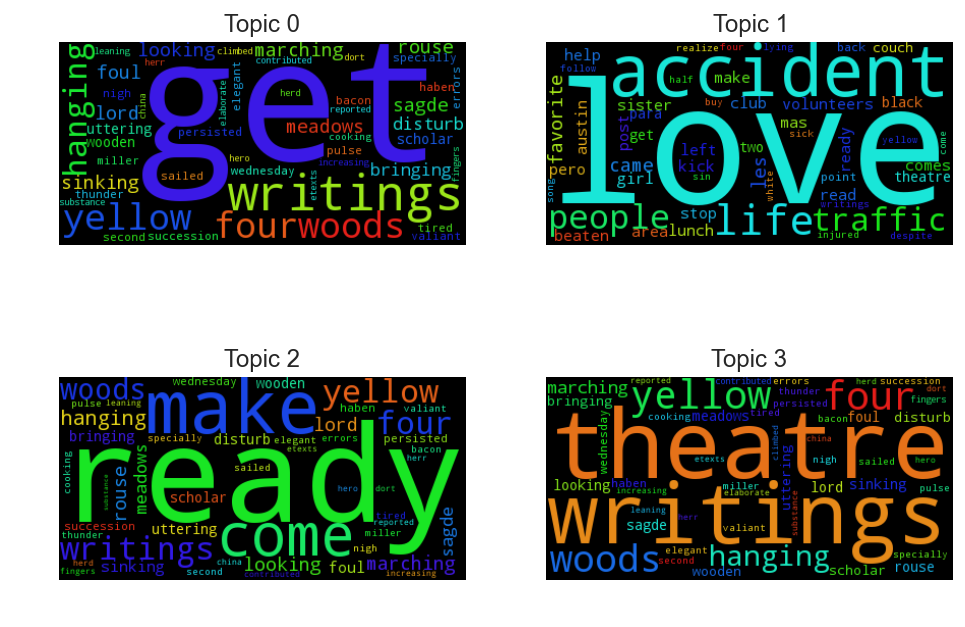

ChunkedEncodingError: ('Connection broken: IncompleteRead(0 bytes read, 512 more expected)', IncompleteRead(0 bytes read, 512 more expected))

In [12]:
BATCH_SIZE = 20
CLUSTER_SIZE = 4

kmeans = MiniBatchKMeans(n_clusters=CLUSTER_SIZE)

def batch(iterable, size):
    """ batch("ABCDEFG", 3) -> ABC DEF G """
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([batchiter.next()], batchiter)

with open("dictnostops.txt") as fh:
    words = [line.strip() for line in fh.readlines()]
    word_to_index = { word: k for k, word in enumerate(words) }

def wordclouds(wordcounts):
    wordclouds = [WordCloud().fit_words(counts) for counts in wordcounts]
    fig, axes = plt.subplots(2,2)
    display.clear_output(wait=True)
    for k, (ax, wordcloud) in enumerate(zip(axes.flatten(), wordclouds)):
        ax.axis("off")
        ax.imshow(wordcloud)
        ax.set_title("Topic %d" % k)
    display.display(fig)
    fig.clear()

try:
    for tweets in batch(islice(tweet_generator(), 1000), BATCH_SIZE):
        mat = sp.sparse.dok_matrix((BATCH_SIZE, len(words)))
        for row, tweet in enumerate(tweets):
            for word in tweet.lower().split():
                if word in word_to_index:
                    mat[row, word_to_index[word]] = 1.
        kmeans.partial_fit(mat.tocsr())
        wordcounts = [
            nlargest(50, zip(words, kmeans.cluster_centers_[i]))
            for i in xrange(kmeans.n_clusters)
        ]
        wordclouds(wordcounts)
except KeyboardInterrupt:
    pass

## Topic Modelling

1. [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) was develoepd by [David Blei, Andrew Ng, and Michael Jordan](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf).  Here's a [Bayesian](https://en.wikipedia.org/wiki/Bayesian_probability) [Graphical Model](https://en.wikipedia.org/wiki/Graphical_model):
    ![LDA](lda1.png)
1. LDA is a topic model:
    ![LDA](lda2.png)

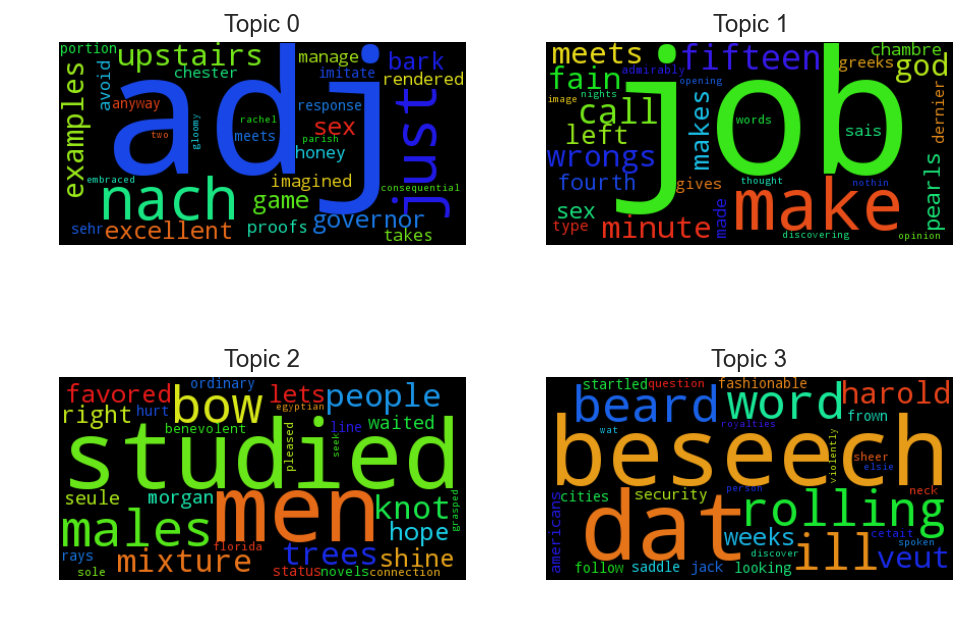

ChunkedEncodingError: ('Connection broken: IncompleteRead(0 bytes read, 512 more expected)', IncompleteRead(0 bytes read, 512 more expected))

In [14]:
K = 4
D = 1e9
BATCH_SIZE = 20
olda = onlineldavb.OnlineLDA(words, K, D, 1./K, 1./K, 1024., 0.7)

try:
    for tweets in batch(islice(tweet_generator(), 1000), BATCH_SIZE):
        olda.update_lambda(list(tweets))
        wordclouds(olda.topic_words(30))
except KeyboardInterrupt:
    pass

## If you want more ....

If you enjoyed this and want to learn more about doing data science in industry, consider [applying](https://www.thedataincubator.com/#apply&ref=ds30) to be a fellow at [The Data Incubator](https://www.thedataincubator.com/&ref=ds30)

If you would like to hire data scientists, introduce data science corporate training, or partner to bring The Data Incubator to your country, reach out [here](https://www.thedataincubator.com/#hire&ref=ds30).
